In [17]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller


In [18]:
covid=pd.read_csv("./covid_19_data.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [19]:
covid.drop(["SNo"],1,inplace=True)


In [20]:
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [21]:
countrywise["Active Cases"]=(countrywise["Confirmed"]-countrywise["Recovered"]-countrywise["Deaths"])
countrywise["Outcome Cases"]=(countrywise["Recovered"]+countrywise["Deaths"])


In [22]:
country_date=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
confirm_rate=[]
for country in countrywise.index:
    days=country_date.loc[country].shape[0]
    confirm_rate.append((countrywise.loc[country]["Confirmed"])/days)
countrywise["Confirm Cases/Day"]=confirm_rate

In [23]:
countrywise["Survival Probability"]=(1-(countrywise["Deaths"]/countrywise["Confirmed"]))*100


In [24]:
X=countrywise[["Confirmed","Deaths","Recovered"]]


In [25]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X=std.fit_transform(X)

In [27]:
wcss = []
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Silhouette Score Method')

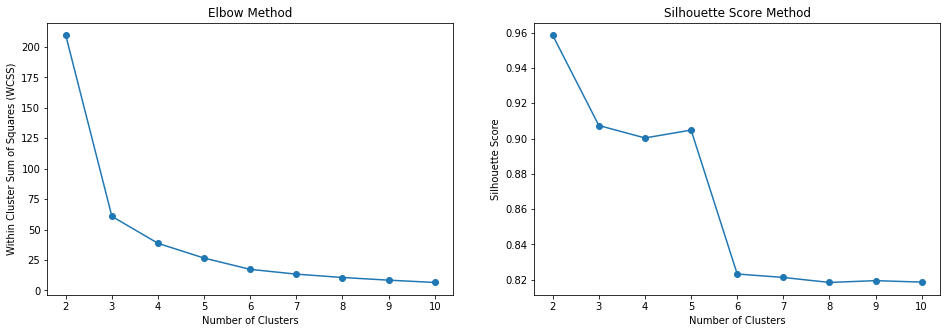

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,11)
ax1.plot(x,wcss,marker='o')
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,11)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

# Lets consider K = 5


In [29]:
clf_final=KMeans(n_clusters=5,init='k-means++',random_state=42)
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [30]:
countrywise["Clusters"]=clf_final.predict(X)

# Summary of clusters 